# Recurrent Neural Networks and The Yield Curve 

Objectives:
- Learning Multistep, multifeature time series modelling
- Naive Bayes -> ARIMA -> Advanced RNN (GRU)

Today we will be exploring yield curves spreads and using data from **Quandl**. Quandl offers quick and easy API's to use and retrieve for free, and already in DataFrame form. Who says a free lunch doesn't exist!


- Here is the data: https://www.quandl.com/data/USTREASURY/YIELD-Treasury-Yield-Curve-Rates
- Here is a tutorial to install Quandl: https://www.quandl.com/tools/python

In [140]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import statsmodels.api as sm
import pandas as pd

In [2]:
import quandl
df = quandl.get("USTREASURY/YIELD", authtoken="s-LF8xGE9kdc-bsVjrUN")

In [3]:
df.head(5)

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09


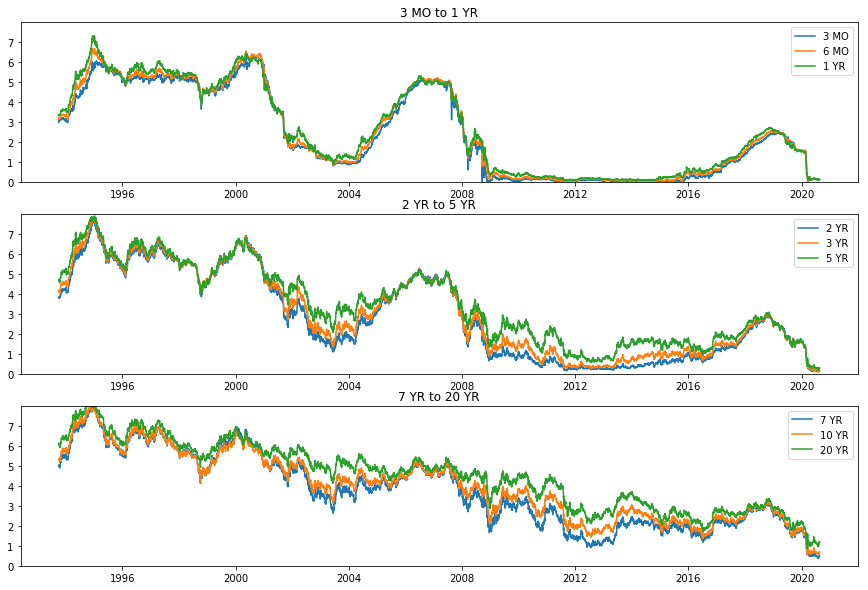

In [4]:
# This is method is equivalent to washing your hands in Covid-19... ALWAYS AND OFTEN!
df.describe()

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
count,4766.000000,461.000000,7662.000000,7665.000000,7665.000000,7665.000000,7665.000000,7665.000000,7665.000000,7665.000000,6726.000000,6671.000000
mean,1.270856,1.583427,2.731989,2.861763,2.987211,3.286359,3.502050,3.894647,4.199678,4.435725,4.531448,4.974601
std,1.472238,0.899828,2.285446,2.319905,2.319355,2.340891,2.290303,2.175329,2.084402,1.975701,1.658242,1.908541
min,0.000000,0.000000,0.000000,0.020000,0.080000,0.110000,0.100000,0.190000,0.360000,0.520000,0.870000,0.990000
25%,0.070000,0.640000,0.252500,0.420000,0.560000,0.950000,1.380000,1.830000,2.250000,2.650000,2.920000,3.120000
50%,0.880000,1.950000,2.355000,2.460000,2.570000,2.960000,3.270000,3.810000,4.060000,4.340000,4.670000,4.790000
75%,1.920000,2.380000,4.990000,5.110000,5.110000,5.380000,5.510000,5.730000,5.950000,5.950000,5.830000,6.495000
max,5.270000,2.480000,8.260000,8.490000,8.640000,9.050000,9.110000,9.100000,9.120000,9.090000,8.300000,9.180000


We are going to drop a couple features (Maturities). In specfic: the 1 month, the 2 month and 30 year. The 1 month was created in '01, the 30 year was removed in '01 and brought back in. Anyhow, sparse data makes things a little more confusing for time series modelling so we are going to remove them. 

In [5]:
type(df)

pandas.core.frame.DataFrame

In [6]:
df = df.drop(['1 MO','2 MO','30 YR'], axis = 1)
df = df.dropna(axis = 0)

In [7]:
df

,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR
Date,,,,,,,,,
1993-10-01,2.98,3.11,3.35,3.84,4.18,4.72,5.03,5.34,6.12
1993-10-04,3.02,3.17,3.35,3.85,4.16,4.71,5.04,5.34,6.10
1993-10-05,3.06,3.20,3.38,3.86,4.18,4.72,5.05,5.35,6.12
1993-10-06,3.04,3.19,3.36,3.85,4.16,4.70,5.05,5.35,6.12
1993-10-07,3.05,3.17,3.35,3.83,4.15,4.69,5.05,5.33,6.11
...,...,...,...,...,...,...,...,...,...
2020-08-13,0.10,0.12,0.14,0.16,0.19,0.32,0.52,0.71,1.20
2020-08-14,0.10,0.12,0.13,0.14,0.18,0.29,0.51,0.71,1.21
2020-08-17,0.10,0.12,0.13,0.14,0.18,0.29,0.49,0.69,1.19


,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR
Date,,,,,,,,,
1993-10-01,2.98,3.11,3.35,3.84,4.18,4.72,5.03,5.34,6.12
1993-10-04,3.02,3.17,3.35,3.85,4.16,4.71,5.04,5.34,6.10
1993-10-05,3.06,3.20,3.38,3.86,4.18,4.72,5.05,5.35,6.12
1993-10-06,3.04,3.19,3.36,3.85,4.16,4.70,5.05,5.35,6.12
1993-10-07,3.05,3.17,3.35,3.83,4.15,4.69,5.05,5.33,6.11
...,...,...,...,...,...,...,...,...,...
2020-08-13,0.10,0.12,0.14,0.16,0.19,0.32,0.52,0.71,1.20
2020-08-14,0.10,0.12,0.13,0.14,0.18,0.29,0.51,0.71,1.21
2020-08-17,0.10,0.12,0.13,0.14,0.18,0.29,0.49,0.69,1.19


In [80]:
df.index.year

Int64Index([1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993,
            ...
            2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020],
           dtype='int64', name='Date', length=6723)

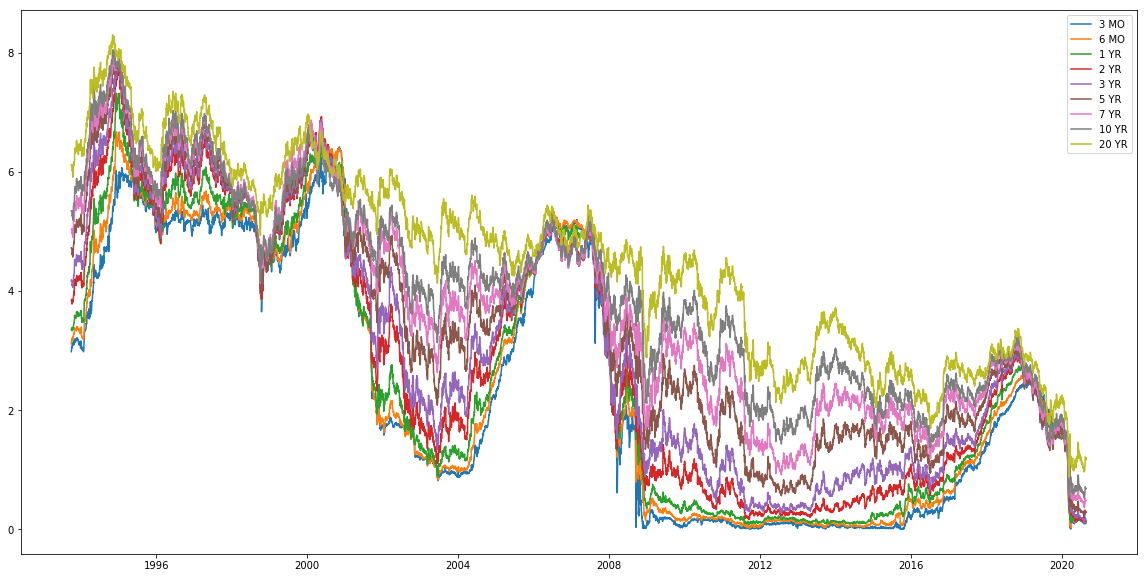

In [8]:
plt.figure(figsize=(20,10));
plt.plot(df);
plt.legend(df);

IndexError: index 3 is out of bounds for axis 0 with size 3

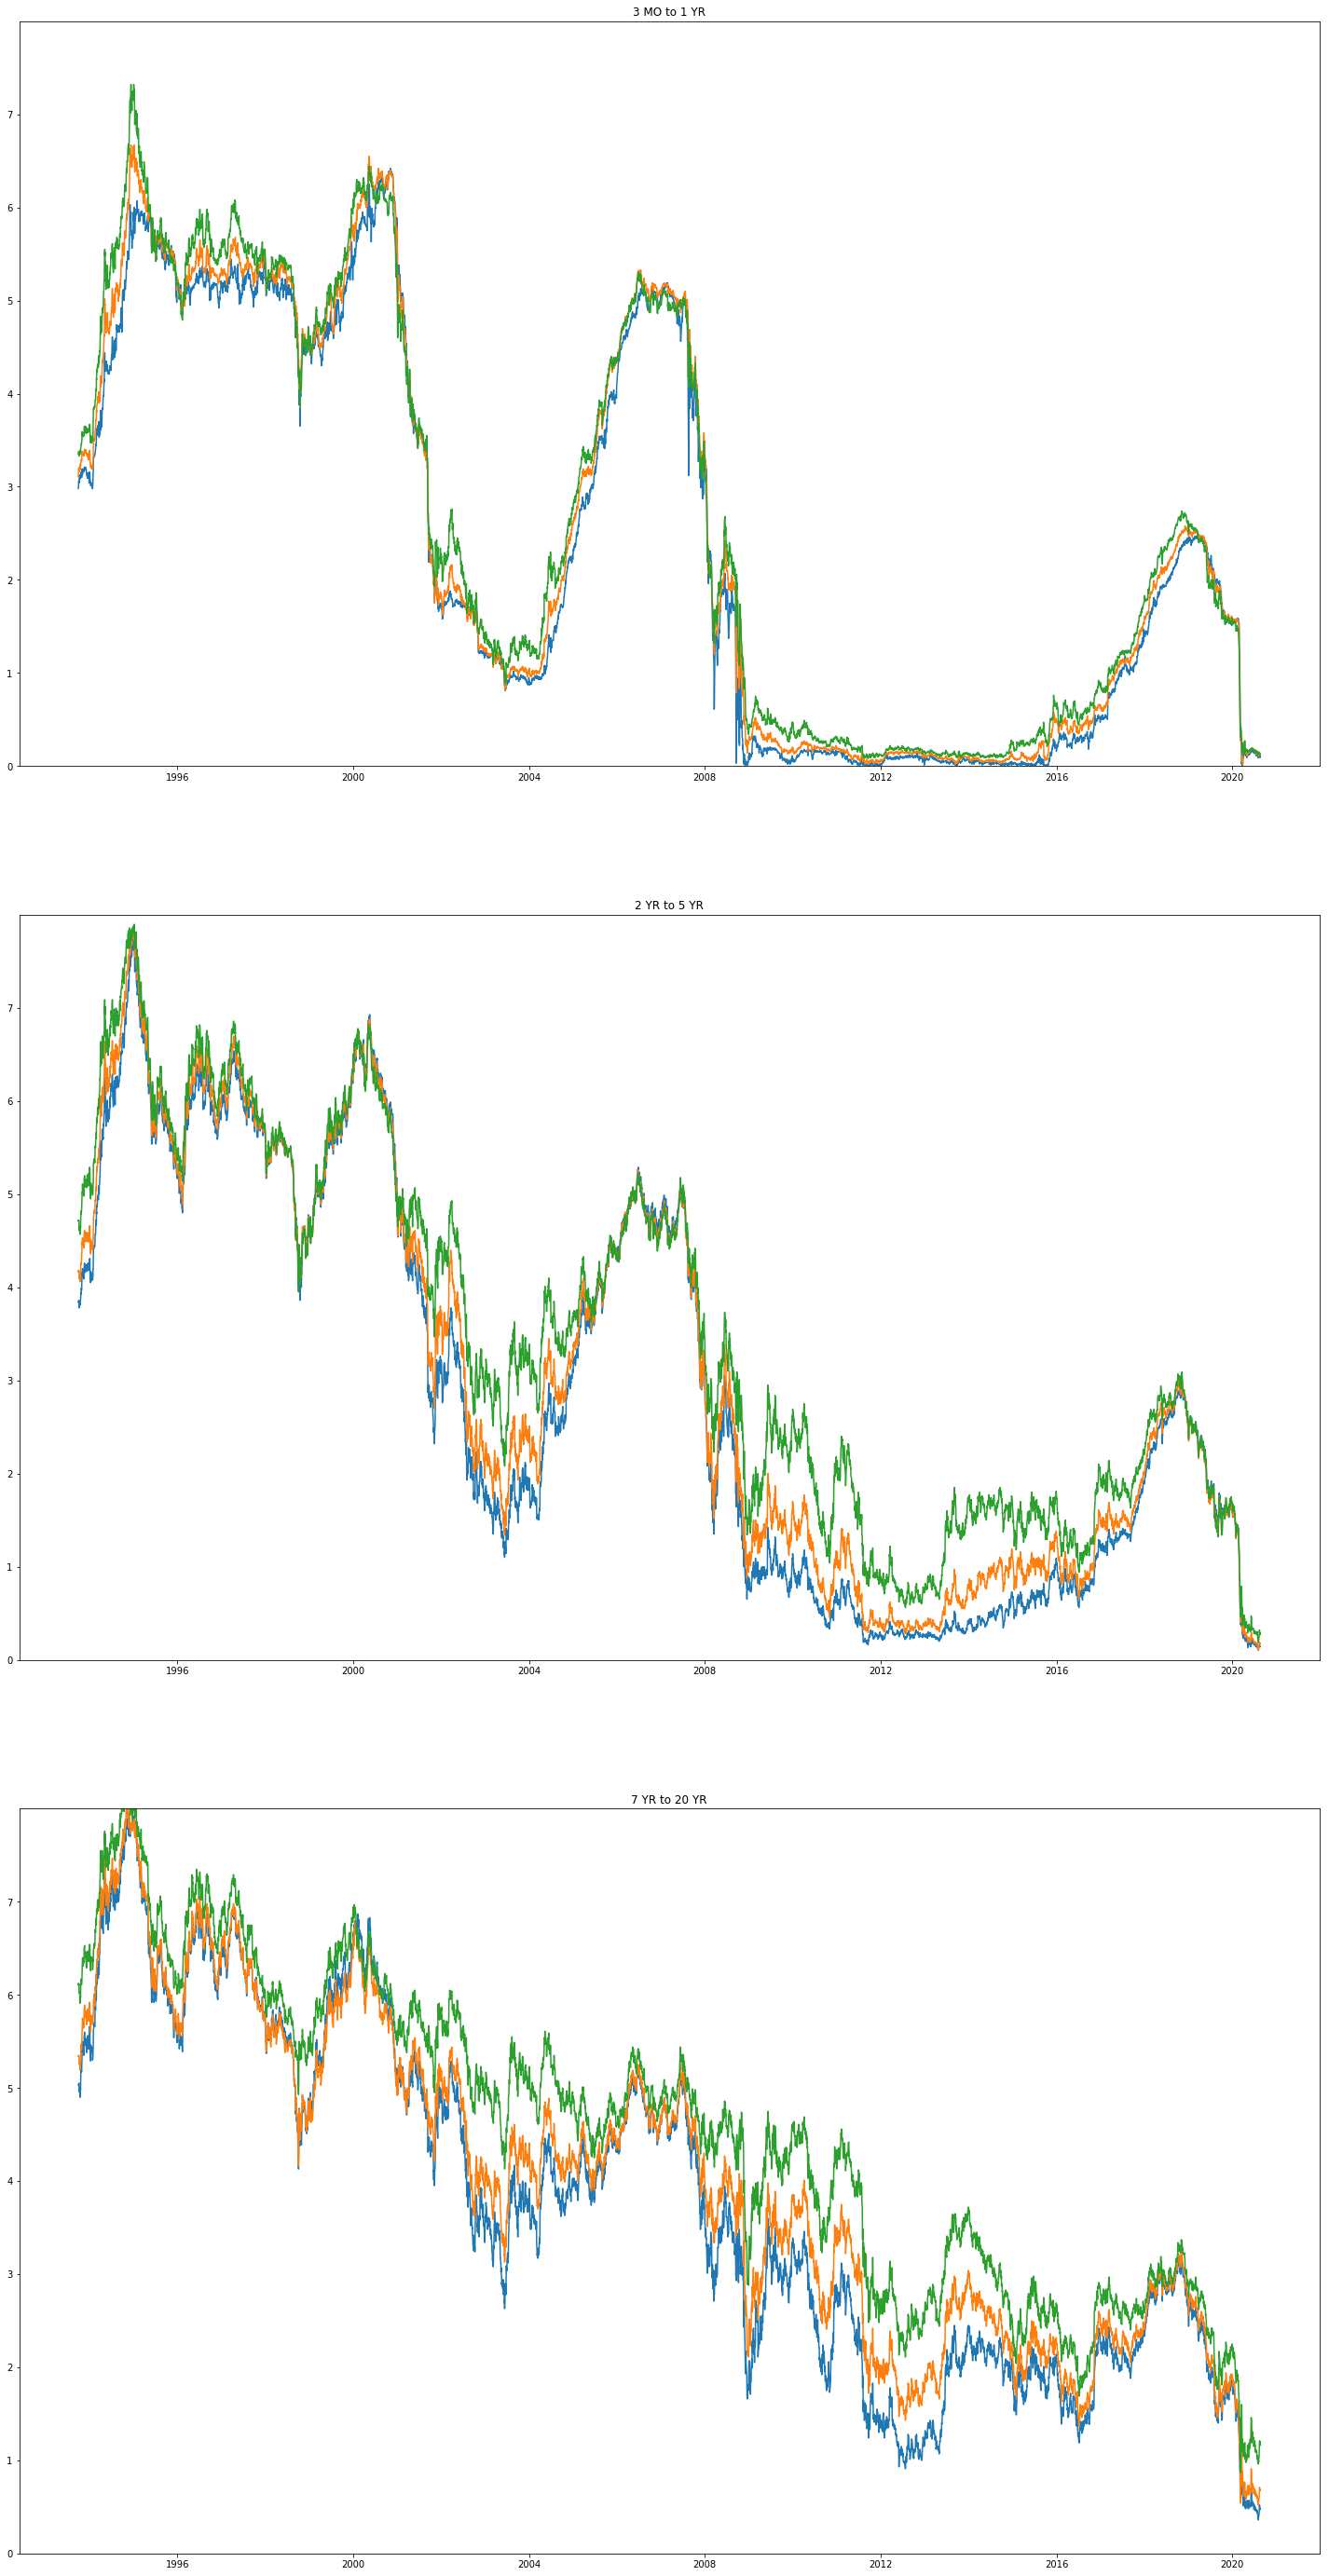

In [457]:
f, axes = plt.subplots(3, 1, figsize=(25, 50))
j = 0

while j < 3:
    for i in range(0,len(df),3):
        temp = df.iloc[:,i:i+3]
        axes[j].set_ylim((0,8))
        axes[j].set_yticks(np.arange(0, 8, 1))
        axes[j].set_title(f"{temp.columns[0]} to {temp.columns[-1]}")
        axes[j].plot(temp)  
        j += 1

### Yearly Yield curve plots
- Lets plot the yield curve over an annual basis. 
- 2 Steps:
1. Groupby year and take the mean value
2. Transpose the dataset

In [271]:
dfyear = df.groupby(df.index.year).mean()
dfystd = df.groupby(df.index.year).std()

In [272]:
dfyear.head(5)


,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR
Date,,,,,,,,,
1993,3.132903,3.306290,3.528710,4.085000,4.408710,4.977903,5.333387,5.615968,6.285968
1994,4.372490,4.826506,5.317470,5.942972,6.270442,6.688273,6.907711,7.085181,7.490080
1995,5.660360,5.817560,5.942120,6.151440,6.254720,6.383320,6.496440,6.573920,6.954640
1996,5.145595,5.290635,5.515913,5.844960,5.994802,6.182103,6.343770,6.443532,6.826111
1997,5.201440,5.390160,5.631520,5.990880,6.102960,6.224680,6.326920,6.353960,6.686840


In [320]:
dfystd

,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR
Date,,,,,,,,,
1993,0.050777,0.070181,0.101731,0.155213,0.172165,0.202072,0.209041,0.210421,0.167826
1994,0.798743,0.927014,1.008228,0.978855,0.930071,0.806113,0.725545,0.665725,0.549137
1995,0.221006,0.351246,0.525907,0.656932,0.680560,0.681138,0.653812,0.630063,0.568746
1996,0.101766,0.158970,0.283406,0.412689,0.440883,0.442621,0.419016,0.403634,0.354751
1997,0.102555,0.112860,0.175028,0.234276,0.271121,0.305811,0.312417,0.337215,0.343594
1998,0.359078,0.373829,0.443142,0.514566,0.507353,0.526838,0.466201,0.424912,0.275368
1999,0.297304,0.366975,0.385703,0.445856,0.461298,0.482092,0.506381,0.475559,0.394280
2000,0.265588,0.201352,0.187331,0.387246,0.416417,0.442287,0.424276,0.391931,0.315021
2001,1.116287,1.065265,0.887453,0.699559,0.571981,0.379573,0.326441,0.285667,0.213432


In [273]:
yieldcurvestd = dfystd.T 
yieldcurvestd

Date,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
3 MO,0.050777,0.798743,0.221006,0.101766,0.102555,0.359078,0.297304,0.265588,1.116287,0.189192,...,0.047916,0.021913,0.025426,0.013848,0.065651,0.085153,0.244715,0.294299,0.336178,0.616493
6 MO,0.070181,0.927014,0.351246,0.158970,0.112860,0.373829,0.366975,0.201352,1.065265,0.239987,...,0.050353,0.024124,0.023533,0.019636,0.129732,0.079997,0.249673,0.278445,0.357119,0.600726
1 YR,0.101731,1.008228,0.525907,0.283406,0.175028,0.443142,0.385703,0.187331,0.887453,0.376551,...,0.069172,0.023732,0.017165,0.034308,0.130983,0.108397,0.252874,0.279459,0.386050,0.566602
2 YR,0.155213,0.978855,0.656932,0.412689,0.234276,0.514566,0.445856,0.387246,0.699559,0.636042,...,0.208644,0.035563,0.059177,0.091342,0.132113,0.150979,0.192446,0.259540,0.385958,0.539994
3 YR,0.172165,0.930071,0.680560,0.440883,0.271121,0.507353,0.461298,0.416417,0.571981,0.723426,...,0.350387,0.059765,0.157305,0.117959,0.128306,0.204619,0.157294,0.231089,0.386051,0.519648
5 YR,0.202072,0.806113,0.681138,0.442621,0.305811,0.526838,0.482092,0.442287,0.379573,0.700338,...,0.527494,0.126960,0.341822,0.091374,0.138051,0.256950,0.131895,0.174009,0.390135,0.487680
7 YR,0.209041,0.725545,0.653812,0.419016,0.312417,0.466201,0.506381,0.424276,0.326441,0.618093,...,0.594196,0.186113,0.421110,0.121477,0.156872,0.277623,0.117261,0.159978,0.390477,0.454840
10 YR,0.210421,0.665725,0.630063,0.403634,0.337215,0.424912,0.475559,0.391931,0.285667,0.536607,...,0.626627,0.205378,0.413890,0.198238,0.166284,0.283955,0.108628,0.155953,0.402192,0.428569
20 YR,0.167826,0.549137,0.568746,0.354751,0.343594,0.275368,0.394280,0.315021,0.213432,0.380278,...,0.671842,0.228110,0.387958,0.282485,0.202224,0.288214,0.105597,0.151695,0.364554,0.371788


In [323]:
yieldcurvesdf = dfyear.T
yieldcurvesdf


Date,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
3 MO,3.132903,4.372490,5.66036,5.145595,5.20144,4.90696,4.777211,5.999920,3.478669,1.63532,...,0.05284,0.08760,0.05708,0.03272,0.052510,0.31936,0.94896,1.971687,2.10576,0.509500
6 MO,3.306290,4.826506,5.81756,5.290635,5.39016,5.02016,4.945817,6.173984,3.453065,1.71648,...,0.09572,0.13384,0.08832,0.06460,0.165498,0.46304,1.07044,2.144819,2.10944,0.520563
1 YR,3.528710,5.317470,5.94212,5.515913,5.63152,5.05252,5.083108,6.112948,3.490000,2.00188,...,0.18088,0.17484,0.13116,0.12112,0.322709,0.61432,1.20288,2.330843,2.05212,0.513188
2 YR,4.085000,5.942972,6.15144,5.844960,5.99088,5.13052,5.434303,6.260916,3.830887,2.63776,...,0.44936,0.27616,0.30708,0.46208,0.686773,0.83420,1.39920,2.527068,1.96880,0.526625
3 YR,4.408710,6.270442,6.25472,5.994802,6.10296,5.13792,5.492948,6.220598,4.089274,3.09992,...,0.74676,0.38228,0.54284,0.89796,1.024542,1.00400,1.57720,2.626627,1.93756,0.555125
5 YR,4.977903,6.688273,6.38332,6.182103,6.22468,5.15232,5.550040,6.157769,4.556694,3.81572,...,1.51824,0.76172,1.17208,1.64160,1.531036,1.33472,1.90964,2.748996,1.95300,0.643563
7 YR,5.333387,6.907711,6.49644,6.343770,6.32692,5.27864,5.786255,6.200518,4.881653,4.30460,...,2.15684,1.22044,1.73752,2.14404,1.891195,1.63432,2.15892,2.852209,2.04544,0.808687
10 YR,5.615968,7.085181,6.57392,6.443532,6.35396,5.26288,5.646135,6.030279,5.020685,4.61308,...,2.78164,1.80344,2.35016,2.53956,2.138287,1.83744,2.32948,2.911245,2.14140,0.936250
20 YR,6.285968,7.490080,6.95464,6.826111,6.68684,5.71596,6.197809,6.230916,5.632177,5.43160,...,3.61756,2.54180,3.11828,3.07264,2.547530,2.21860,2.65196,3.018233,2.40132,1.352063


In [358]:
yieldcurvestd.iloc[:,0]

3 MO     0.050777
6 MO     0.070181
1 YR     0.101731
2 YR     0.155213
3 YR     0.172165
5 YR     0.202072
7 YR     0.209041
10 YR    0.210421
20 YR    0.167826
Name: 1993, dtype: float64

A little difficult to decipher which is where, lets separate this into subplots. How about 7 plots with 4 lines each?

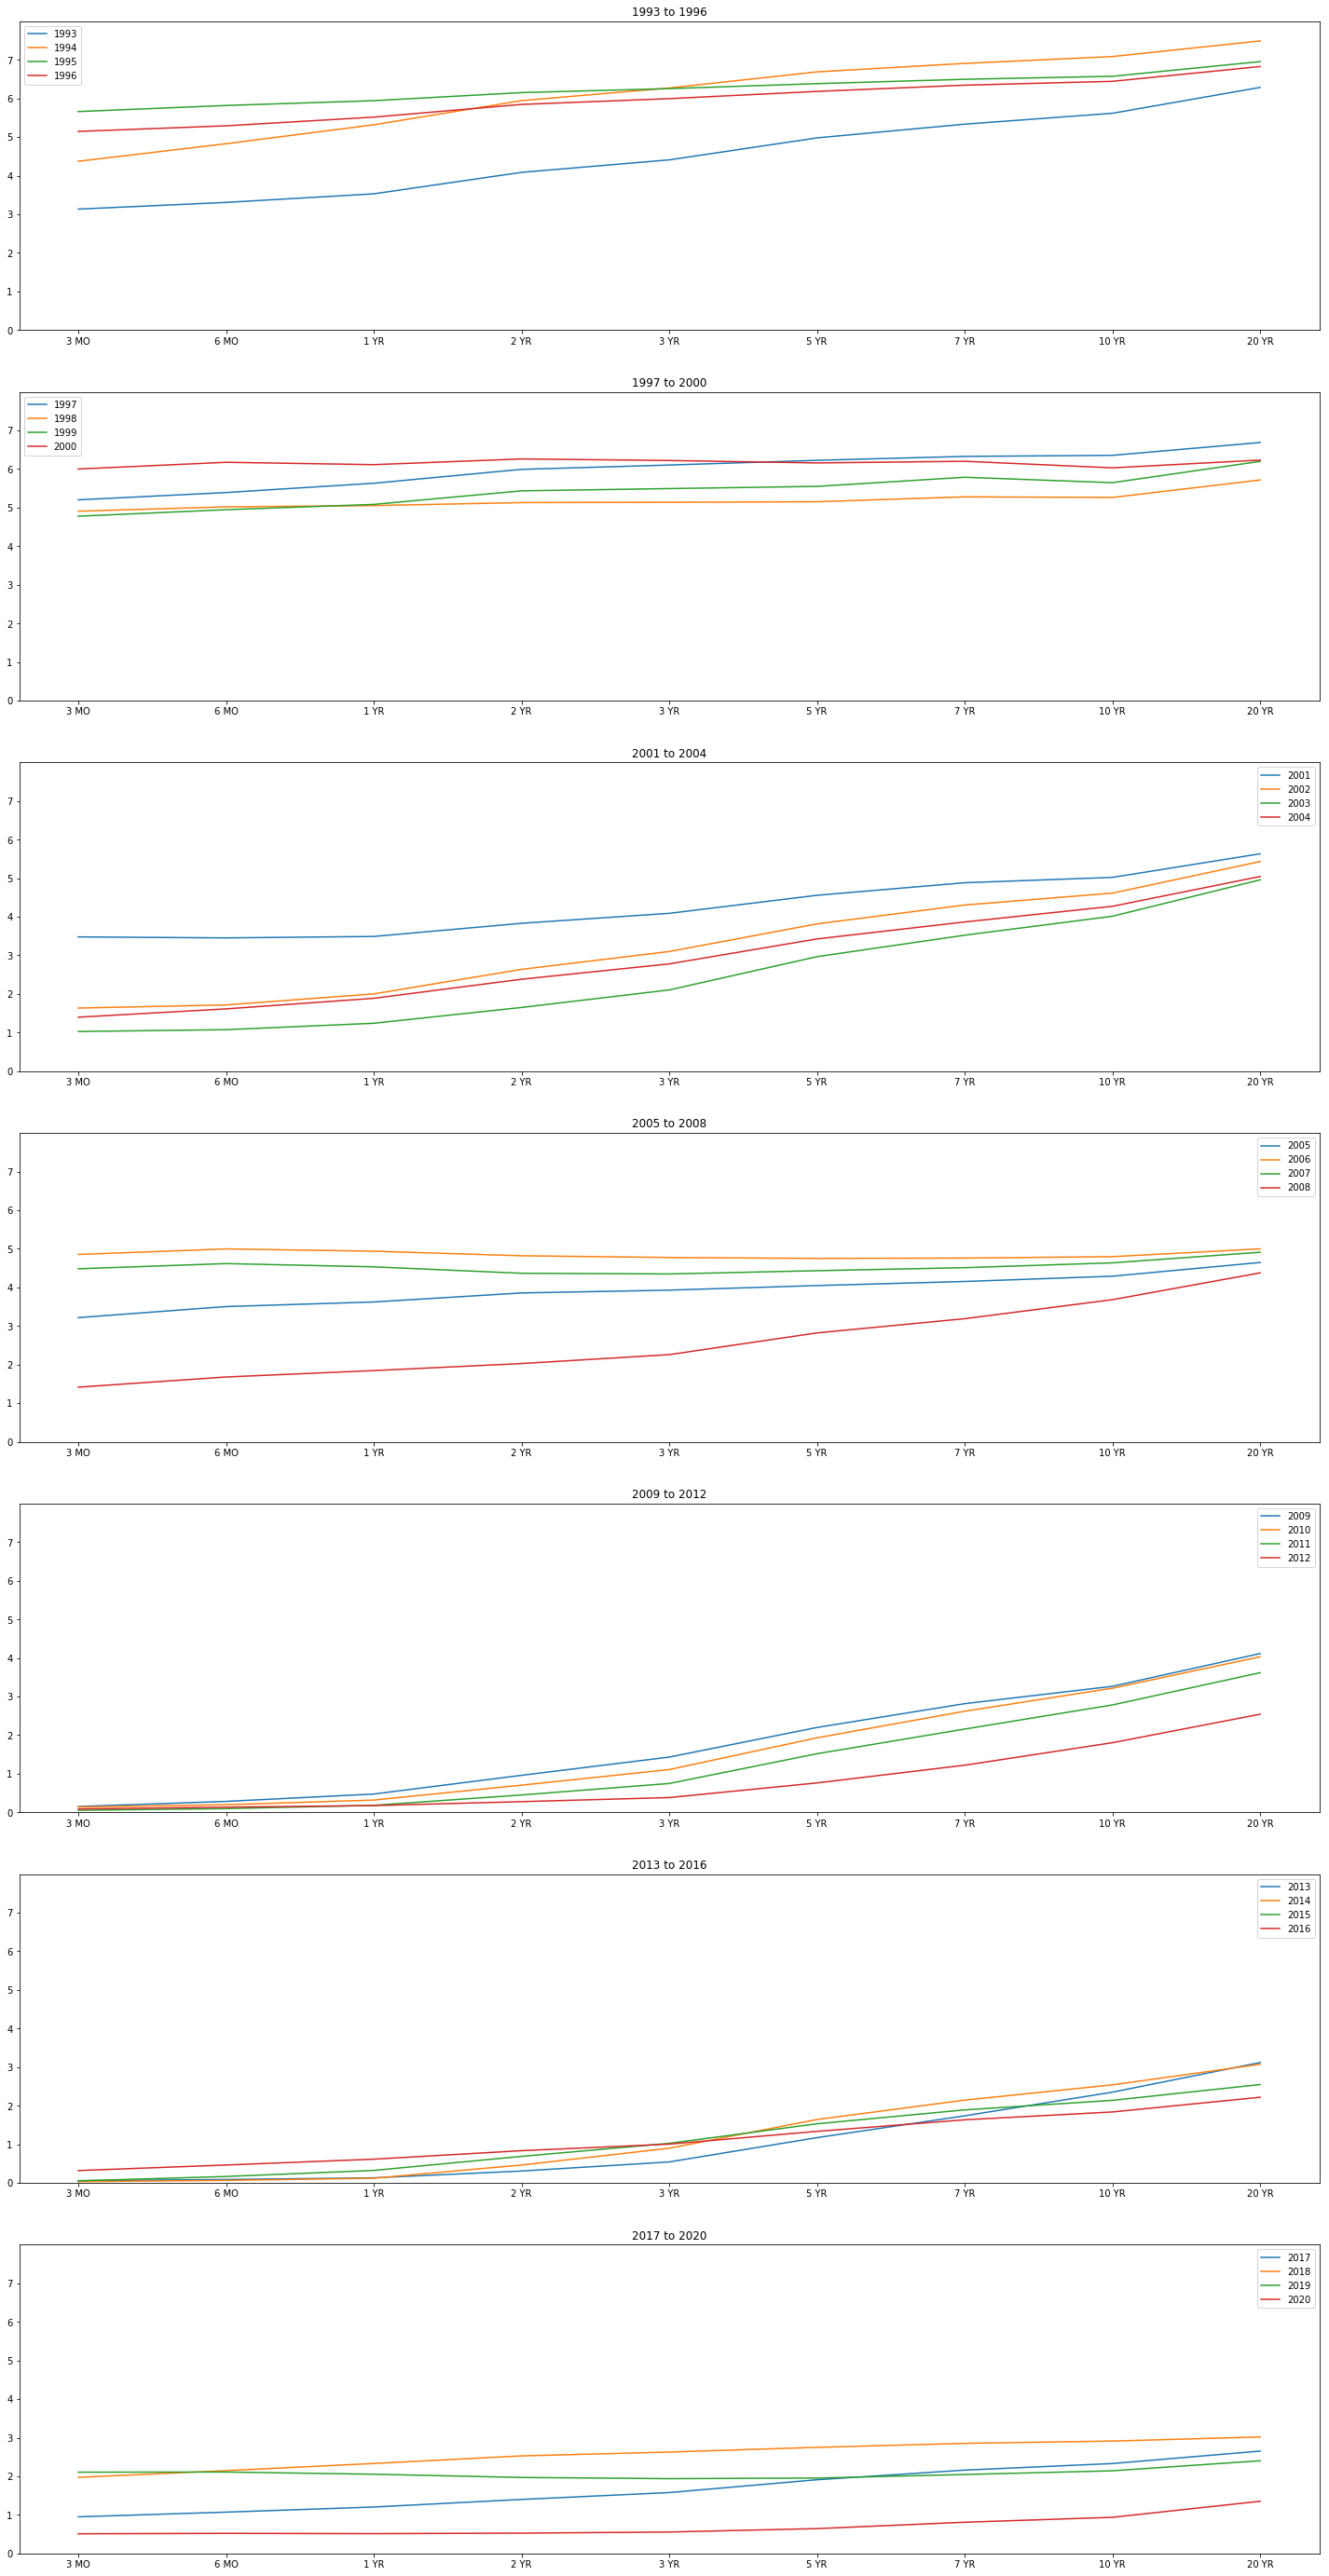

In [374]:
f, axes = plt.subplots(7, 1, figsize=(25, 50))
j = 0
while j < 7:
    for i in range(0,len(dfyear),4):
        new = yieldcurvesdf.iloc[:,i:i+4]
        axes[j].set_ylim((0,8))
        axes[j].set_yticks(np.arange(0, 8, 1))
        axes[j].set_title(f"{new.columns[0]} to {new.columns[-1]}")
        axes[j].plot(new, label = new.columns)
        axes[j].legend(new)
        
        j += 1

In [268]:
yieldcurvesdf.index

Index(['3 MO', '6 MO', '1 YR', '2 YR', '3 YR', '5 YR', '7 YR', '10 YR',
       '20 YR'],
      dtype='object')

This is a good generalization of the yield curve for each year, but lets add a `fill_between` of 1 standard deviation for each maturity at each given year 

In [359]:
yieldcurvesdf.index

temp = yieldcurvesdf.iloc[:,0]
temp 



3 MO     3.132903
6 MO     3.306290
1 YR     3.528710
2 YR     4.085000
3 YR     4.408710
5 YR     4.977903
7 YR     5.333387
10 YR    5.615968
20 YR    6.285968
Name: 1993, dtype: float64

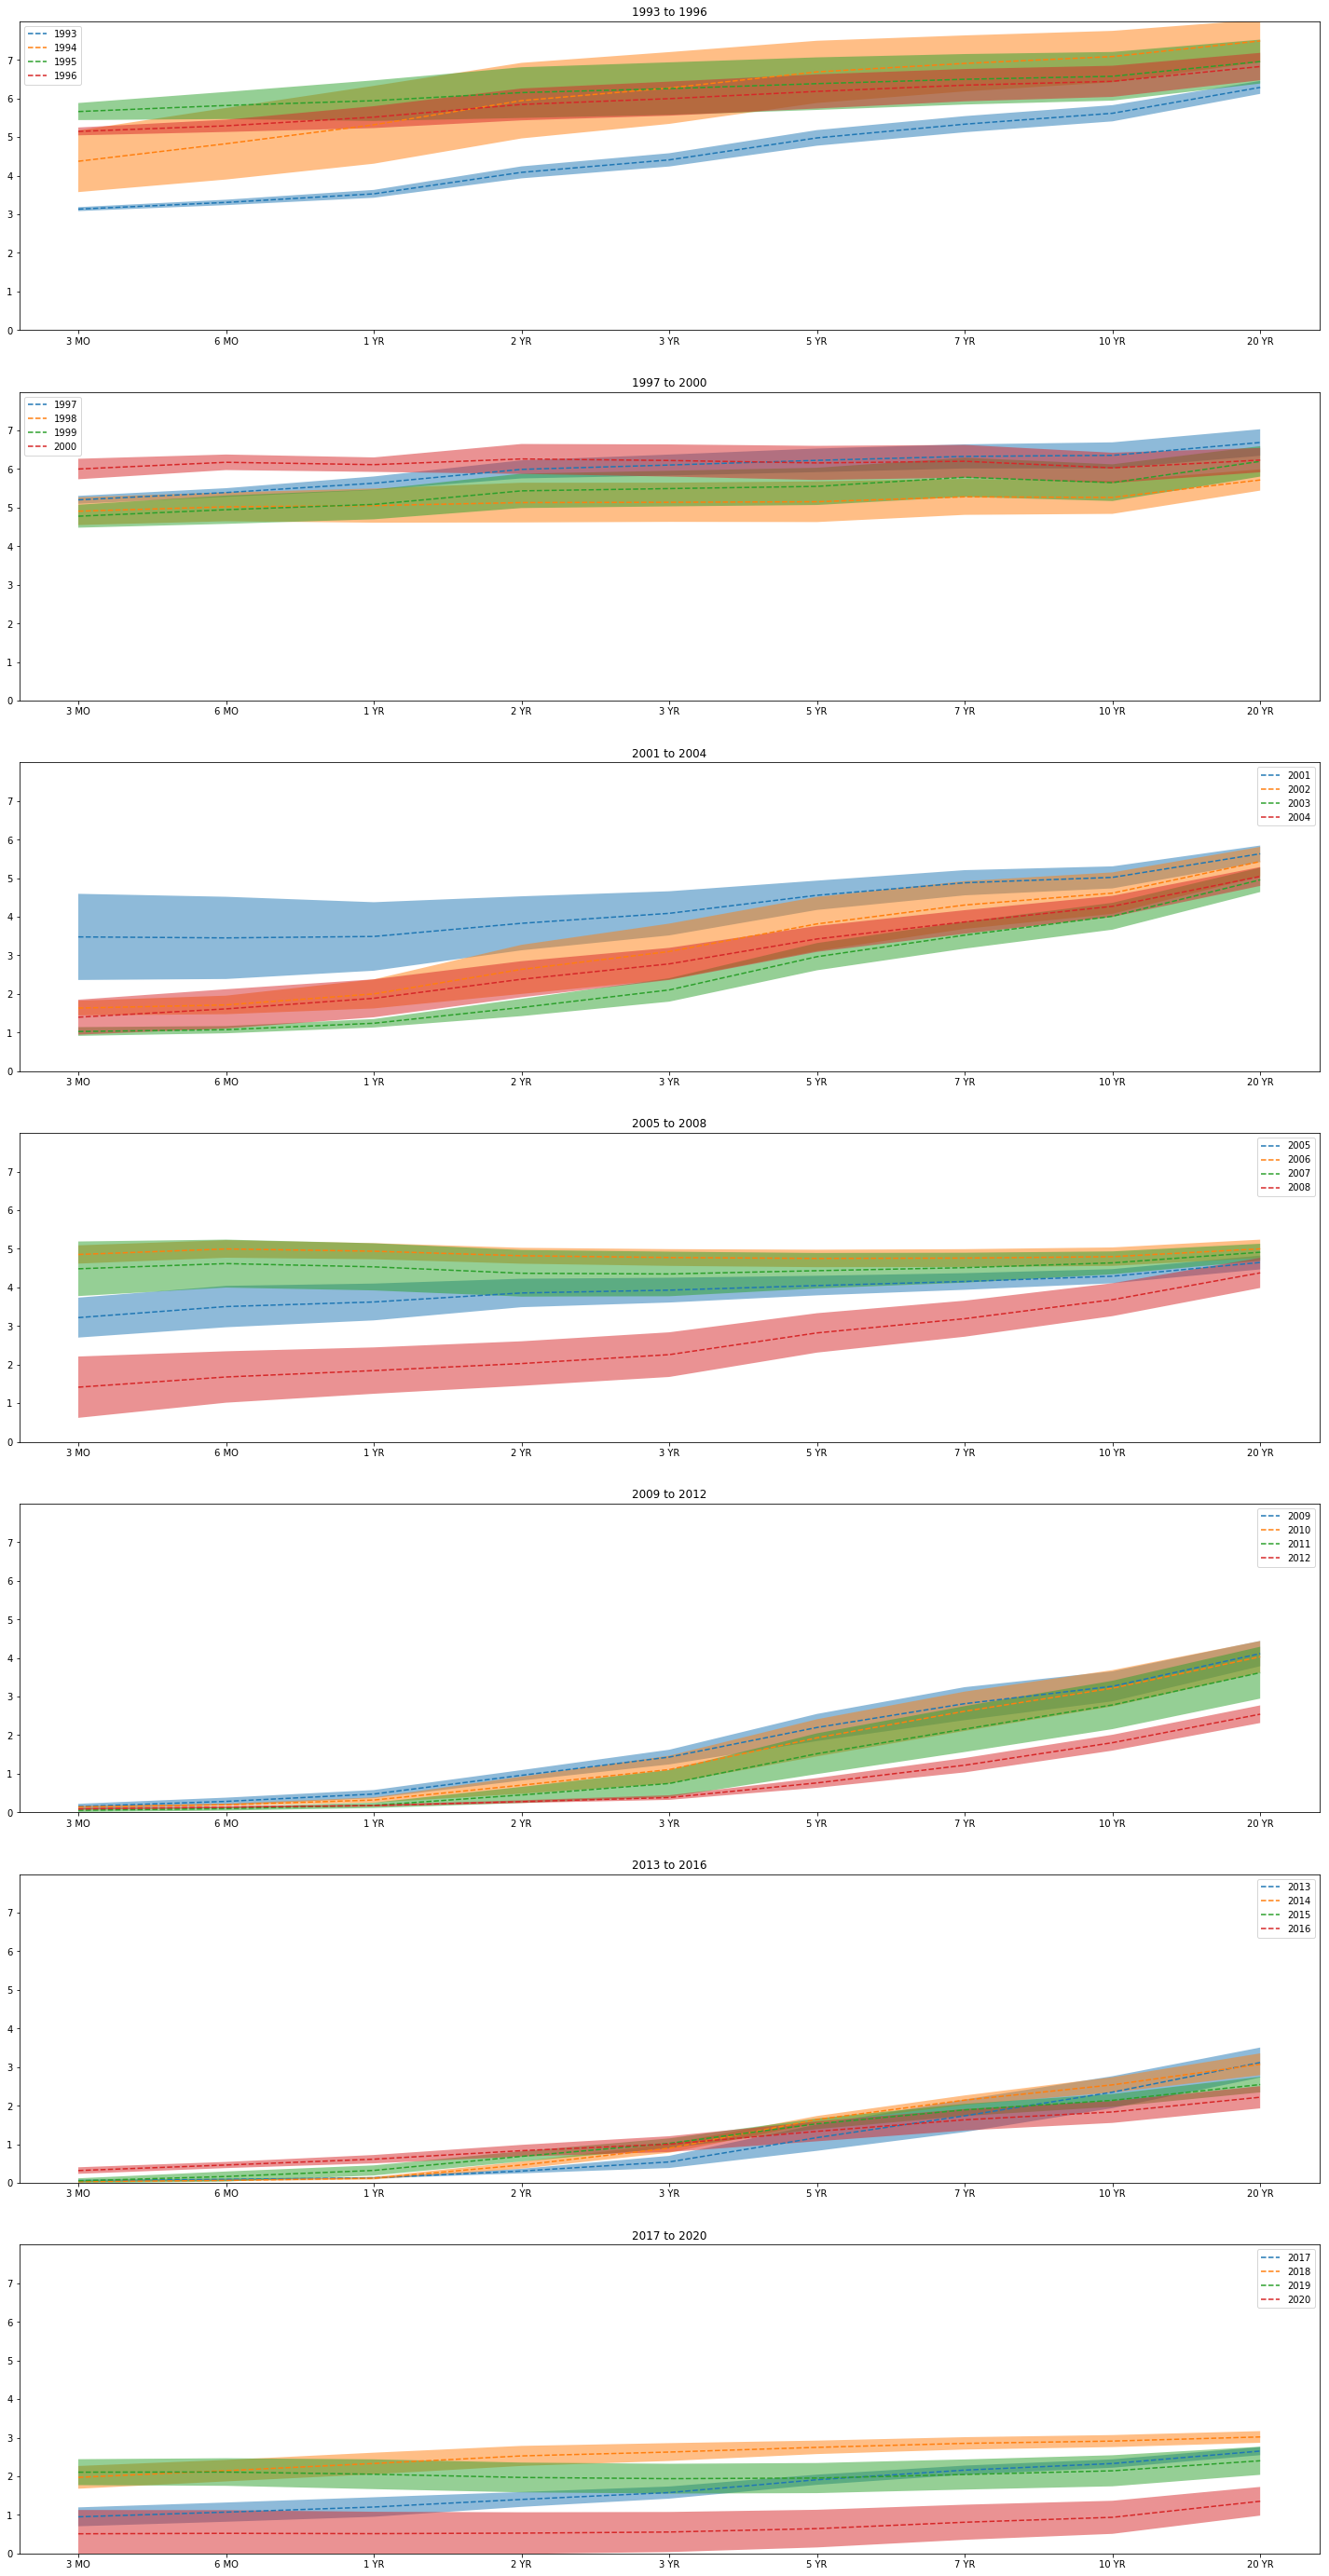

In [399]:
f, axes = plt.subplots(7, 1, figsize=(25, 50))
j = 0
while j < 7:
    for i in range(0,len(dfyear),4):
        temp = yieldcurvesdf.iloc[:,i:i+4]
        temp2 = yieldcurvestd.iloc[:,i:i+4]
        axes[j].set_ylim((0,8))
        axes[j].set_yticks(np.arange(0, 8, 1))
        axes[j].set_title(f"{temp.columns[0]} to {temp.columns[-1]}")
        axes[j].plot(temp, linestyle = '--')
        for k in range(4):
            axes[j].fill_between(x = yieldcurvesdf.index, y1 = temp.values[:,k] + temp2.values[:,k], y2 = temp.values[:,k] - temp2.values[:,k],
                                alpha=0.5, label = '± σ')
        axes[j].legend(temp)
        
        j += 1
        


## Interpretation of The Yield Curve

This plot offers a lot of fundamental information about the macroeconomic climate. For example, one can observe multiple differences in

**Level** - A parallel increase or decrease in the interest rates.

**Steepness** - Long term interest rates increased while short term rates decreased. 

**Curvature** - Short term and long term increases while intermediate term has little change

Also, we have plotted a 
`average rate ± σ `for each individual year to observe the annual volatilty. For example, 2001 had high amounts of volatility in the short-term interest rate market. In comparison to 2011, where there is little volatility in the short and intermediate term interest rate market while spread in the long term market (10-20 years) exhbits some variance 

This is important for security holdings because interest rate volatility is the cause of price volatility. The assumed/ typical volatility structure is that short term rates are more volatile (greater standard deviation) than long-term rates. Although, the data data visualization clearly shows some exceptions.

There are several theories for the reasonance of yield curve shapes. There is **Unbiased Expectations Theory**, **Local Expectations Theory**, **Liquidity Preference Theory**, **Segmented Markets Theory** and **Preferred Habitat Theory**. I just graduated from my Economics BA, so I am pretty jaded when it comes to explaining theory, so the astute reader can feel free to Investopedia these things! 


# Splitting data

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

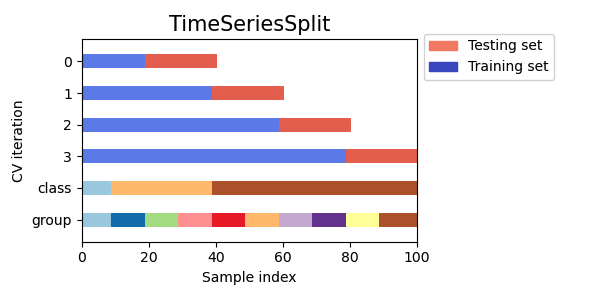

## Augmented Dick-Fuller Test 
- To be continued:
- Test for stationairity

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

In [430]:
for i in range(len(df.columns)):
    adf, p, usedlag, nobs, cvs, bic = sm.tsa.stattools.adfuller(df.iloc[:,i], autolag = "BIC")
    print(f'{df.columns[i]}\n\t t-stat and p-val:{adf}, {p}\n\t Optimized lag: {bic}')

3 MO
	 t-stat and p-val:-0.7140598066845376, 0.8430740415520551
	 Optimized lag: -21758.02054243697
6 MO
	 t-stat and p-val:-0.813422263547149, 0.8151475497896561
	 Optimized lag: -24071.34024849675
1 YR
	 t-stat and p-val:-0.46115890999738607, 0.8993758194725536
	 Optimized lag: -23363.58318477584
2 YR
	 t-stat and p-val:-0.6522032151869745, 0.8587447156487977
	 Optimized lag: -20160.035383327326
3 YR
	 t-stat and p-val:-0.7315571824121543, 0.8384053339284485
	 Optimized lag: -19313.590337345595
5 YR
	 t-stat and p-val:-0.8276901538688421, 0.8108526876906386
	 Optimized lag: -18544.933916708876
7 YR
	 t-stat and p-val:-0.8559039203554368, 0.8021469918587318
	 Optimized lag: -18425.782708996747
10 YR
	 t-stat and p-val:-0.8207306388806641, 0.8129566296552637
	 Optimized lag: -19073.939871485934
20 YR
	 t-stat and p-val:-0.7775658110298322, 0.8256232885719779
	 Optimized lag: -19849.625195478162


In [429]:
len(df.columns)

9

In [210]:
data = df.to_numpy()
np.ndim(data)
np.shape(data)

(6723, 9)

In [208]:
def generator(data, lookback, delay, min_index, max_index = None, 
              shuffle = False, batch_size= 128, step = 6):
    
    '''
data: The original array of floating point data, which we just normalized in the code snippet above.
lookback: How many timesteps back should our input data go.
delay: How many timesteps in the future should our target be.
min_index and max_index: Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another one for testing.
shuffle: Whether to shuffle our samples or draw them in chronological order.
batch_size: The number of samples per batch.
step: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.
    '''
    if max_index is None:
        #Setting index for code
        max_index = len(data) - delay - 1 
    i = min_index + lookback 
    
    while 1:
        if shuffle:
            
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else: 
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step,
                               data.shape[-1]))
        targets = np.zeros((len(rows),data.shape[-1]))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay]# What is this 1 doing here?
            
        yield samples, targets   

   


In [413]:
df.columns[0]

'3 MO'

In [212]:
gen = generator(data, lookback = 5, min_index = 0, batch_size = 250, delay = 5,step = 1)

(-0.9467010008501356,
 0.7722045192671629,
 17,
 6705,
 {'1%': -3.4313256607414933,
  '5%': -2.861971160680042,
  '10%': -2.566999503197776},
 -19095.4331496027)

In [216]:
for i in gen:
    i

KeyboardInterrupt: 

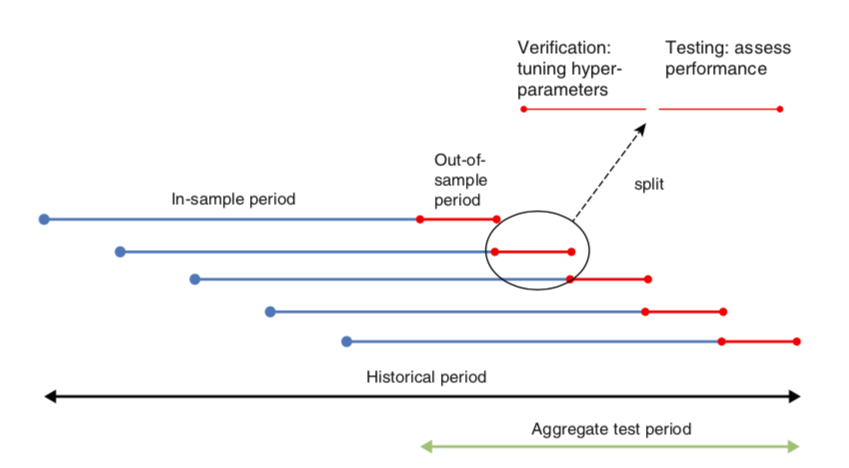
(Dixon, 2020)

In [ ]:
def CV_walkforward(data, lags, steps, AggTestRatio = 0.4, folds = 5):
    max_index = len(data) - steps - 1 #Predicting forward
    insample = np.zeros(len(data)*(1-AggTestRatio),lag, data.shape[-1]) # Shape: 3D tensor = (Length Training Data, lags, features)
    outsample = np.zeros((len(data)*AggTestRatio)/ folds, data.shape[-1]) # Shape: 2D tensor = (Length Data, Features )
    
    
    for i in range()
        
        
        
    

In [ ]:
for j, row in enumerate(data):
    indices = range(data[j] - 7, data[j])

In [ ]:
 samples = np.zeros((len(rows), lookback // step,
                               data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1] # What is this 1 doing here?
            
        yield samples, targets   

In [ ]:

for i in range(window_size, len(data)):
    train = np.array(data[i-window_size:i])
    test = np.array(data[i:i+3])
    splits.append(('TRAIN:', train, 'TEST:', test))


In [342]:
yieldcurvesdf.xindex

Index(['3 MO', '6 MO', '1 YR', '2 YR', '3 YR', '5 YR', '7 YR', '10 YR',
       '20 YR'],
      dtype='object')